# <span style="color:green"><center>Diplomado en Inteligencia Artificial y Aprendizaje Profundo</center></span>

# <span style="color:red"><center>Tensorborad en Pytorch</center></span>

##   Profesores

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Campo Elías Pardo Turriago, cepardot@unal.edu.co 

## Asistentes

5. Oleg Jarma, ojarmam@unal.edu.co 
6. Laura Lizarazo, ljlizarazore@unal.edu.co
7. Julieth López, julalopezcas@unal.edu.co

## Contenido

* [¿Qué es Tensorborad?]()
    * [Tablero de tensorBoard]()
* [Requerimientos]()
* [Instalación y carga]()
* [Ejemplo]()
    * [Modelo]()
    * [Graficando imaganes con TensorBoard]()
    * [Inspeción del modelo usando TensorBoard]()
    * [Agregando la pesataña "proyector" a Tensorboard]()
    * [Rastreo del entrenamiento del modelo con TensorBoard]()
* [Referencias]()

# ¿Qué es Tensorborad?

Para ver lo que está sucediendo durante el entrenamiento de un modelo es posible imprimir algunas estadísticas a medida que el modelo se está entrenando para tener un de su progreso. Sin embargo, se puede hacer mucho mejor ya que PyTorch se integra con Tensorboard, una herramienta diseñada para visualizar los resultados de las carreras de entrenamiento de red neuronal. Este tutorial ilustra parte de su funcionalidad, utilizando el conjunto de datos de Mnist que se puede leer en Pytorch usando `TorchVision.Datasets`. Algunas de las pestañas del tablero de Tensorboard se describen a continuación.

## Tablero de tensorBoard

- **Scalars**: Muestra los cambios en la perdida y métricas cobre las epocas. Tambien puede usarse para rastrear otros valores escalares como la taza de aprendizaje y la velocidad de entrenamiento.
- **Images**: Tiene imagenes que muestran los pesos. Parandose con sobre una epoca especifica se pueden ver los pesos del modelo en esa epoca.
- **Graphs**: Muestra las capas del modelo. Se puede utilizar para revisar si la arquitectura del modelo es la que se pretende.
- **Distributions**: Muestra la distribución de los tensores. Por ejemplo, se puede ver la distribucion de los pesos y sesgos sobre cada epoca en una capa específica.
- **Histograms**: Muestra la distribución de los tensores sobre el tiempo, sobre cada epoca.
- **Projector**: Se puede utilizar para visualizar la representación de cada vector, por ejemplo, word embeddings (la representación numérica de las palabras que captura su relación semantica) y imágenes.

# Requerimientos

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Instalación y carga

Se puede utlizar ´pip´ o ´conda´ para la **instalación**, observe los siguientes comandos:

`pip install torch torchvision`

`conda install pytorch torchvision -c pytorch`

Se puede **cargar** Tensorboard utilizando Jupyter notebook, Jupyter lab o Google Colab.

In [2]:
%load_ext tensorboard

Tensorboard genera unos archivos "logs" o "registros" del codigo que se ejecuta y que deben ser guaradados.

In [3]:
log_folder = 'logs_pytorch1'

En caso de querer recargar la extensión se puede utilizar el siguiente código.

In [4]:
%reload_ext tensorboard

Para limpiar los `logs` y dejar libre el folder se pueden correr los siguientes comandos:

- Para linux: `rm -rf logs`
- Para colab: `!rm -rf /logs/`
- Para windows utilizar ambos:
    - `!taskkill /f /t /im tensorboard.exe`
    - `!del /a /s /q /f logs`

In [5]:
# Clear out any prior log data.
!taskkill /f /t /im tensorboard.exe
!del /a /s /q /f {log_folder}

ERROR: no se encontr¢ el proceso "tensorboard.exe".
No se pudo encontrar C:\Users\JULIETH LOPEZ\Documents\Diplomado_IA_AP\logs_pytorch1


# Ejemplo

Usaremos TensorBoard para visualizar las metricas de un modelo. Construiremos para ello un modelo sencillo de clasificación de imágenes. Inicialmente las salidas de la base de datos de torchvision son imagenes en un rango de [0, 1], así que las transformamos en tensores normalizados con un rango de [-1, 1].

In [6]:
# transformación
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datos
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# Clases
classes = ('Zero','One','Two','Three','Four','Five','Six','Seven','Eight','Nine')

# Función auxiliar para mostrar una imagen (utilizado en la función `plot_classes_preds`)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

## Modelo

Definiremos una arquitectura simple, debemos tener en cuenta que las imágenes son de un canal, no de tres y son de tamaño 28x28:

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

Definimos el  optimizador y el criterio:

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Antes de correr el modelo se debe crear una instancis de `SummaryWriter`.

In [9]:
writer = SummaryWriter(log_dir=log_folder)

## Graficando imagenes con TensorBoard

Ahora vamos a escribir imagenes en Tensorboard, específicamente, una cuadrícula, usando `Make_Grid`.

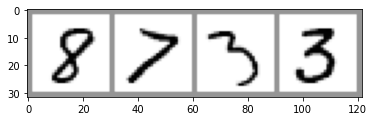

In [10]:
# Imágenes aleatoria de entrenamiento
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Grilla de imagenes
img_grid = torchvision.utils.make_grid(images)

# Mostrar imágenes
matplotlib_imshow(img_grid, one_channel=True)

# Escribir en Tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

## Inspeción del modelo usando TensorBoard

Una de las fortalezas de Tensorboard es su capacidad para visualizar estructuras modelo complejas. Visitemos el modelo que construimos.

In [11]:
writer.add_graph(net, images)
writer.close()

## Agregando la pesataña "proyector" a Tensorboard

Podemos visualizar la representación dimensional inferior de datos dimensionales más altos a través del método `Add_Medding`.

In [12]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# selección de imágenes aleatorias y sus etiquetas
images, labels = select_n_random(trainset.data, trainset.targets)

# obtener las etiquetas de la clase para cada imagen
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

En la pestaña **Projector** se pueden ver las 100 imágenes (de dimensión 784) proyectadas en un espacio de 3 dimensiones. Además, es intecractvo, se puede girar la proyección.

## Rastreo del entrenamiento del modelo con TensorBoard

Esta herramienta puede servir para realizar una evaluación más clara del modelo y como evoluciona durante el entrenamiento. Registraremos la pérdida de ejecución en Tensorboard, junto con una vista a las predicciones.

In [13]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 3))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

Finalmente, entrenemos el modelo, pero escribamos los resultados en Tensorboard cada 1000 lotes,esto se hace utilizando la función `Add_Scalar`. Además, a medida que entrenamos, generaremos una imagen que muestra las predicciones del modelo contra los resultados reales en las cuatro imágenes incluidas en ese lote.

In [14]:
running_loss = 0.0
for epoch in range(3):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


Ahora se puede ver la pestaña *Scalars* para ver la pérdida de ejecución sobre las 15.000 iteraciones de capacitación:

In [15]:
%tensorboard --logdir={log_folder}

Además, podemos ver las predicciones del modelo realizado en lotes arbitrarios durante el aprendizaje. En la pestaña "Imágenes" se puede ver la visualización de "predicciones vs. reales".

# Referencias
* [Visualizing Models, Data, and Training with TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)
* [How to use TensorBoard with PyTorch](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html)
* [Torch.utils.tensorboard](https://pytorch.org/docs/stable/tensorboard.html)